In [203]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

torch.Size([1, 1, 512, 512])


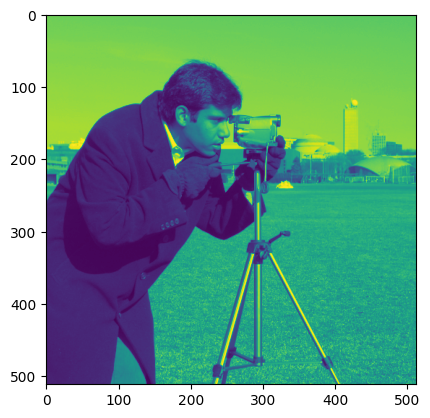

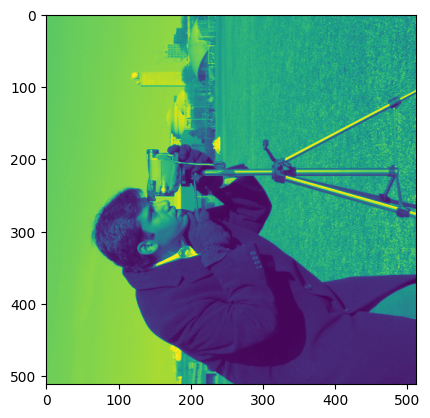

In [204]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from skimage import data

camera = K.image_to_tensor(data.camera(), keepdim=False)
camera = camera.float() / 255.
print(camera.shape)
timg = torch.cat([camera,torch.rot90(camera,1,dims=(2,3))], dim=0)
timg_gray = timg


plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [205]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=120, translate=0.05, p=1.0),
            # kornia.augmentation.RandomPerspective(0.05, p=1),
            data_keys=["input"],
            same_on_batch=False,
            random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return iter(self.data)


def generate_random_points(image_size, num_points):
    # Extrair as dimensões da imagem
    H, W = image_size

    # Gerar tensores de coordenadas aleatórias
    random_coords = torch.rand(num_points, 2)

    # Dimensionar as coordenadas aleatórias de acordo com as dimensões da imagem
    random_coords[:, 0] *= W
    random_coords[:, 1] *= H

    return random_coords

In [206]:
import kornia

img1: torch.Tensor = kornia.image_to_tensor(data.camera(), keepdim=False).float() / 255.
input = torch.cat([img1,img1], dim=0)
B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)

points = generate_random_points((H,W),60).expand(2, -1, -1)
print(points.shape)
shape = input.shape
params_lists =AugmentationParamsGenerator(3,shape)

torch.Size([2, 60, 2])


In [233]:
import matplotlib.pyplot as plt
import kornia

def plot_image_with_keypoints(image_tensor, keypoints_tensor):
    # Converter a imagem tensorial em objeto PIL.Image
    image = kornia.utils.tensor_to_image(image_tensor)
    # Plotar a imagem e os keypoints
    plt.imshow(image)
    if keypoints_tensor is not None:
        # Extrair as coordenadas x e y dos keypoints
        keypoints_x = keypoints_tensor[:,0].flatten().tolist()
        keypoints_y = keypoints_tensor[:,1].flatten().tolist()
        plt.scatter(keypoints_x, keypoints_y, c='red')
    plt.show()
    
def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        False  if not (0 <= ponto[0] <= dimensao_max_x 
                       and 0 <= ponto[1] <= dimensao_max_y 
                       and tensor_mascara[int(ponto[1]), int(ponto[0])]) else True
        for ponto in lista_de_pontos
    ]
    return torch.tensor(pontos_filtrados)

def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        ponto.tolist()  for ponto in lista_de_pontos 
        if 0 <= ponto[0] <= dimensao_max_x 
        and 0 <= ponto[1] <= dimensao_max_y 
        and tensor_mascara[int(ponto[1]), int(ponto[0])] 
    ]
    return torch.tensor(pontos_filtrados)

torch.Size([60, 2])


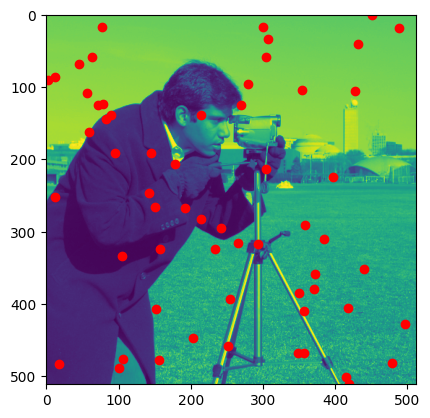

3


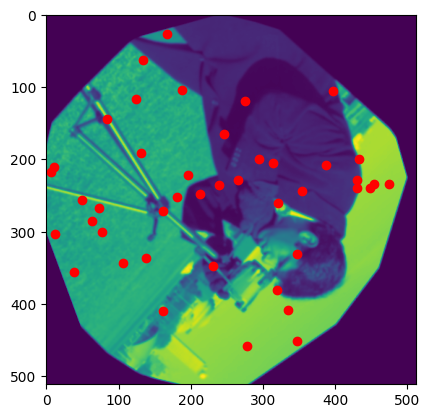

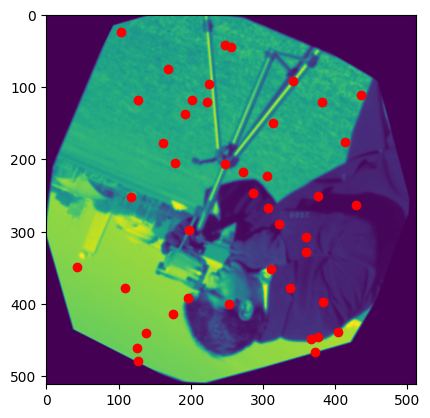

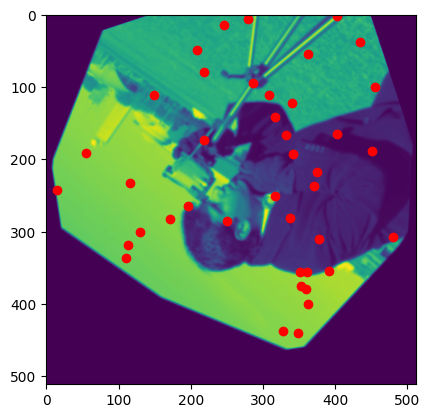

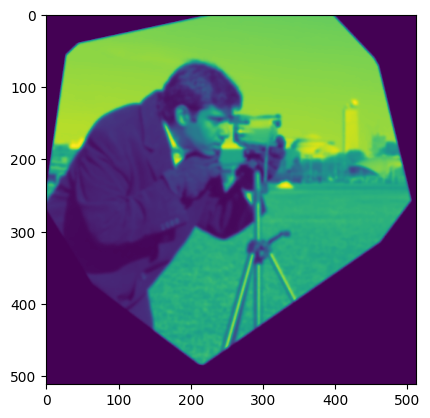

In [234]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=120,translate=0.05,p=1.0),
    # kornia.augmentation.RandomPerspective(0.05, p=1),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=False,
    random_apply=15,
)

print(points[0].shape)
plot_image_with_keypoints(input[0],points[0])

print(len(params_lists.data))
for params in params_lists:
    
    out = aug_list(input, mask, bbox, points,params=params)
    filtered_points = filtrar_keypoints(out[3][0],out[1][0,0].bool())
    plot_image_with_keypoints(out[0][0],filtered_points)
    
out_inv = aug_list.inverse(*out)
plot_image_with_keypoints(out_inv[0][0],None)

torch.Size([41, 2])


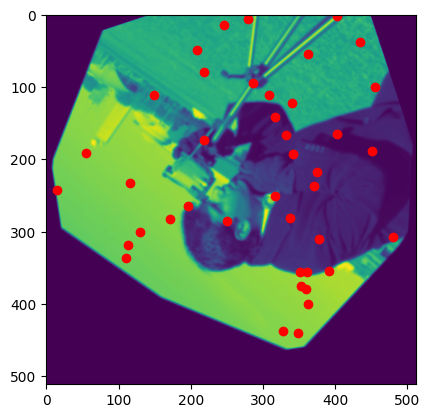

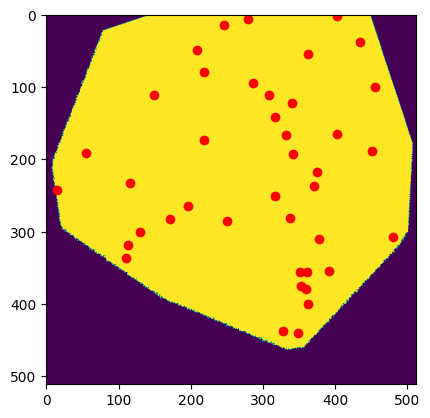

In [209]:
import torch

# Supondo que você tenha os dados de entrada
lista_de_pontos = out[3][0]
tensor_mascara = out[1][0, 0].bool()


# Filtrar keypoints
pontos_filtrados = filtrar_keypoints(lista_de_pontos, tensor_mascara)
print(pontos_filtrados.shape)
plot_image_with_keypoints(out[0][0],pontos_filtrados)
plot_image_with_keypoints(tensor_mascara,pontos_filtrados)

In [222]:
import numpy as np
from scipy.spatial.distance import cdist
def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched

#considerar correspondecia posicional
matches = find_best_matching_indices_knn(lista_de_pontos,pontos_filtrados,0.2)
len(matches),lista_de_pontos.shape,pontos_filtrados.shape

(41, torch.Size([60, 2]), torch.Size([41, 2]))